# Evaluation of all services

* We compute metrics for all 5 services with all 7 evaluator classes (for Gender API and NameAPI we have two approaches)
* We export the tables with those variants of Gender API and NameAPI that perform better
* We compute benchmarks for 3 different metrics by tuning/training the free parameter(s) and reporting the cross validation error

In [1]:
import pandas as pd
import xlsxwriter
from collections import OrderedDict, Counter

from scipy.stats import friedmanchisquare

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set(color_codes=True)

from evaluators import *
from evaluator import *
from config import DIR_PATH

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
REGISTERED_EVALUATORS = [GenderAPIEvaluator, GenderAPIFullEvaluator, \
    NameAPIEvaluator, NameAPIFullEvaluator, GenderGuesserEvaluator, \
    GenderizeIoEvaluator, NamSorEvaluator]

In [3]:
# Color codes for tables
light_green = '#e5ffe5'
dark_green = '#2e992e'

In [4]:
gender_evalautor_to_service_name = {'gender_api': 'Gender API', 'gender_guesser': 'gender-guesser', 
                                    'genderize_io': 'genderize.io', 'name_api_full': 'NameAPI', 'namsor': 'NamSor'}
def reduce_table(df, by_index):
    """Filter rows or columns of a benchmark table and rename."""
    df = df.sort_index()
    if by_index:
        df = df.loc[gender_evalautor_to_service_name.keys()]
        df = df.rename(index=gender_evalautor_to_service_name)
    else:
        df = df[list(gender_evalautor_to_service_name.keys())]
        df.columns = gender_evalautor_to_service_name.values()
        sorted_cols = sorted(df.columns)
        df = df[sorted_cols]
    return df

# Benchmark 1: compute errors without tuning

In [5]:
def compute_all_errors_without_tuning():
    service_to_all_errors = {}
    error_names = ['errorCoded', 'errorCodedWithoutNA', 'errorGenderBias', 'naCoded', 'WeightedError']
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        eval_name = evaluator.gender_evaluator
        evaluator.load_data(evaluated=True)
        evaluator._translate_api_response()
        evaluator.compute_confusion_matrix(evaluator.test_data)
        errors = evaluator.compute_all_errors()
        service_to_all_errors[eval_name] = errors
    all_errors = pd.DataFrame.from_dict(service_to_all_errors, orient='index')
    all_errors.columns = error_names
    return all_errors

In [6]:
cm = sns.light_palette("green", as_cmap=True)
df = compute_all_errors_without_tuning()
df = reduce_table(df, by_index=True)
df = df.round(3)

df.style.background_gradient(cmap=cm)

,errorCoded,errorCodedWithoutNA,errorGenderBias,naCoded,WeightedError
Gender API,0.079,0.05,-0.011,0.03,0.056
genderize.io,0.143,0.05,0.022,0.097,0.07
NameAPI,0.179,0.034,0.004,0.15,0.067
NamSor,0.128,0.043,0.007,0.089,0.061
gender-guesser,0.222,0.026,0.002,0.201,0.073


In [7]:
# # Export tables to Excel files
# df = compute_all_errors_without_tuning()
# df = reduce_table(df, by_index=True)
# df = df.round(3)

# # add colors using ExcelWriter; see http://xlsxwriter.readthedocs.io/working_with_conditional_formats.html
# writer = pd.ExcelWriter(DIR_PATH + '/paper/submission/Table2.xlsx', engine='xlsxwriter')
# df.to_excel(writer, sheet_name='Sheet1')
# workbook  = writer.book
# worksheet = writer.sheets['Sheet1']

# worksheet.conditional_format('B2:B8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})
# worksheet.conditional_format('C2:C8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})
# worksheet.conditional_format('E2:E8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})
# worksheet.conditional_format('F2:F8', {'type': '2_color_scale', 'min_color': light_green, 'max_color': dark_green})

# writer.save()

# Benchmarks by repeated cross validation

The larger the number of parameter values used to fit on the training set, the smaller the error. However, choosing too many parameter values makes it harder to compare services with very few parameters and those with many, and it increases the probability of overfitting.

In what follows, we fit the algorithms on the individual data sets using mostly 10-fold cross-validation, where the training consists of simply trying out parameters from a randomly sampled parameter set from each of the parameter spaces. The size of the sample parameter set depends on the size of the data set: we choose at most 35 parameters for the data set `wos` and only 20 for the smaller data sets `zbmath`, `genderize_r_authors` and `genderize_r_titles`.

We perform the Friedman Test which is a non-parametric test suitable for comparing multiple classifiers on multiple domains. We then apply post-hoc tests to identify the classifiers showing significant difference. For details on significance tests, see 'N. Japkowicz and M. SHah, Statistical Significance Testing. A Classification Perspective. Cambridge University Press. (2011)', in particular Chapter 6 and references cited therein.

### Random parameter sampling for all services

In [8]:
# sample usage
s = REGISTERED_EVALUATORS[0]
evaluator = s('all')
eval_name = evaluator.gender_evaluator
evaluator.load_data(evaluated=True)
evaluator.preprocess_tuning_params()
evaluator._translate_api_response()
evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

evaluator.sample_parameters(n_iter=3)

[{'api_accuracy': 93, 'api_samples': 43826},
 {'api_accuracy': 64, 'api_samples': 257742},
 {'api_accuracy': 99, 'api_samples': 3229},
 {'api_accuracy': 85, 'api_samples': 1593},
 {'api_accuracy': 98, 'api_samples': 2492},
 {'api_accuracy': 98, 'api_samples': 32295},
 {'api_accuracy': 98, 'api_samples': 6302},
 {'api_accuracy': 97, 'api_samples': 1892},
 {'api_accuracy': 56, 'api_samples': 211741},
 {'api_accuracy': 0, 'api_samples': 0}]

In [9]:
def sample_parameters_for_all_services(n_iter=20, method='square', random_state=None):
    """Create sets of parameters randomly drawn from the evaluator's distribution. Choose method 'constant' 
    if you want to have 'n_iter' parameters at most, and method 'square' 
    if you want to have at most n_iter^n parameters, where n is the number of tuning parameters of the evaluator."""
    service_to_param_range = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator.load_data(evaluated=True)
        evaluator.preprocess_tuning_params()
        evaluator._translate_api_response()
        evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
        
        service_to_param_range[evaluator.gender_evaluator] = evaluator.sample_parameters(n_iter=n_iter, 
                                                                                         method=method, 
                                                                                         random_state=random_state)
        
    return service_to_param_range

In [10]:
grid_20_20 = sample_parameters_for_all_services(n_iter=20, method="constant")
grid_30_30 = sample_parameters_for_all_services(n_iter=30, method="constant")
grid_50_50 = sample_parameters_for_all_services(n_iter=50, method="constant")
grid_100_100 = sample_parameters_for_all_services(n_iter=100, method="constant")

grid_20_400 = sample_parameters_for_all_services(n_iter=20, method="square")

In [11]:
# check size of grid per service
dict_of_grids = {"a: 20-20": grid_20_20, "b: 30-30": grid_30_30, "c: 50-50": grid_50_50, 
                             "d: 100-100": grid_100_100, "e: 20-400": grid_20_400}

dict_of_grids = OrderedDict(sorted(dict_of_grids.items(), key=lambda t: t[0]))

for grid_size, service_to_grid in dict_of_grids.items():
    print(grid_size)
    for service, grid in service_to_grid.items():
        print(service, len(grid))

a: 20-20
gender_api 21
genderize_io 21
name_api 13
gender_guesser 3
gender_api_full 21
name_api_full 15
namsor 7
b: 30-30
gender_api 31
genderize_io 30
name_api 21
gender_guesser 3
gender_api_full 31
name_api_full 19
namsor 8
c: 50-50
gender_api 51
genderize_io 49
name_api 28
gender_guesser 3
gender_api_full 51
name_api_full 31
namsor 14
d: 100-100
gender_api 101
genderize_io 90
name_api 41
gender_guesser 3
gender_api_full 100
name_api_full 51
namsor 18
e: 20-400
gender_api 389
genderize_io 331
name_api 10
gender_guesser 3
gender_api_full 377
name_api_full 12
namsor 7


We see the following:

* for `gender_guesser` there are at most 3 parameter values anyway so exhaustive search of parameter space is reached
* the `namsor` parameter space is quite sparse, hence the grid size does not grow as fast; the other 1-parameter service `names_api` (and `names_api_full`) profits more
* the grid sizes for the 2-parameter services `gender_api` (and `gender_api_full`) and `genderize_io` grow almost to the limit of the allowed grid size

In [12]:
grid_20_20['gender_api']

[{'api_accuracy': 99, 'api_samples': 44146},
 {'api_accuracy': 97, 'api_samples': 4881},
 {'api_accuracy': 99, 'api_samples': 50718},
 {'api_accuracy': 100, 'api_samples': 407},
 {'api_accuracy': 99, 'api_samples': 44635},
 {'api_accuracy': 99, 'api_samples': 12231},
 {'api_accuracy': 99, 'api_samples': 18288},
 {'api_accuracy': 62, 'api_samples': 2492},
 {'api_accuracy': 98, 'api_samples': 4098},
 {'api_accuracy': 98, 'api_samples': 11},
 {'api_accuracy': 99, 'api_samples': 5727},
 {'api_accuracy': 50, 'api_samples': 24073},
 {'api_accuracy': 99, 'api_samples': 140849},
 {'api_accuracy': 92, 'api_samples': 7901},
 {'api_accuracy': 99, 'api_samples': 23436},
 {'api_accuracy': 99, 'api_samples': 1102},
 {'api_accuracy': 99, 'api_samples': 139211},
 {'api_accuracy': 68, 'api_samples': 339},
 {'api_accuracy': 99, 'api_samples': 56140},
 {'api_accuracy': 98, 'api_samples': 247084},
 {'api_accuracy': 0, 'api_samples': 0}]

In [13]:
grid_20_20['gender_guesser']

[{'api_confidence': 0.75}, {'api_confidence': 1.0}, {'api_confidence': 0}]

To get an impression of the parameter space. See notebook `Plot_parameter_distribution.ipynb` for plots for the article. 

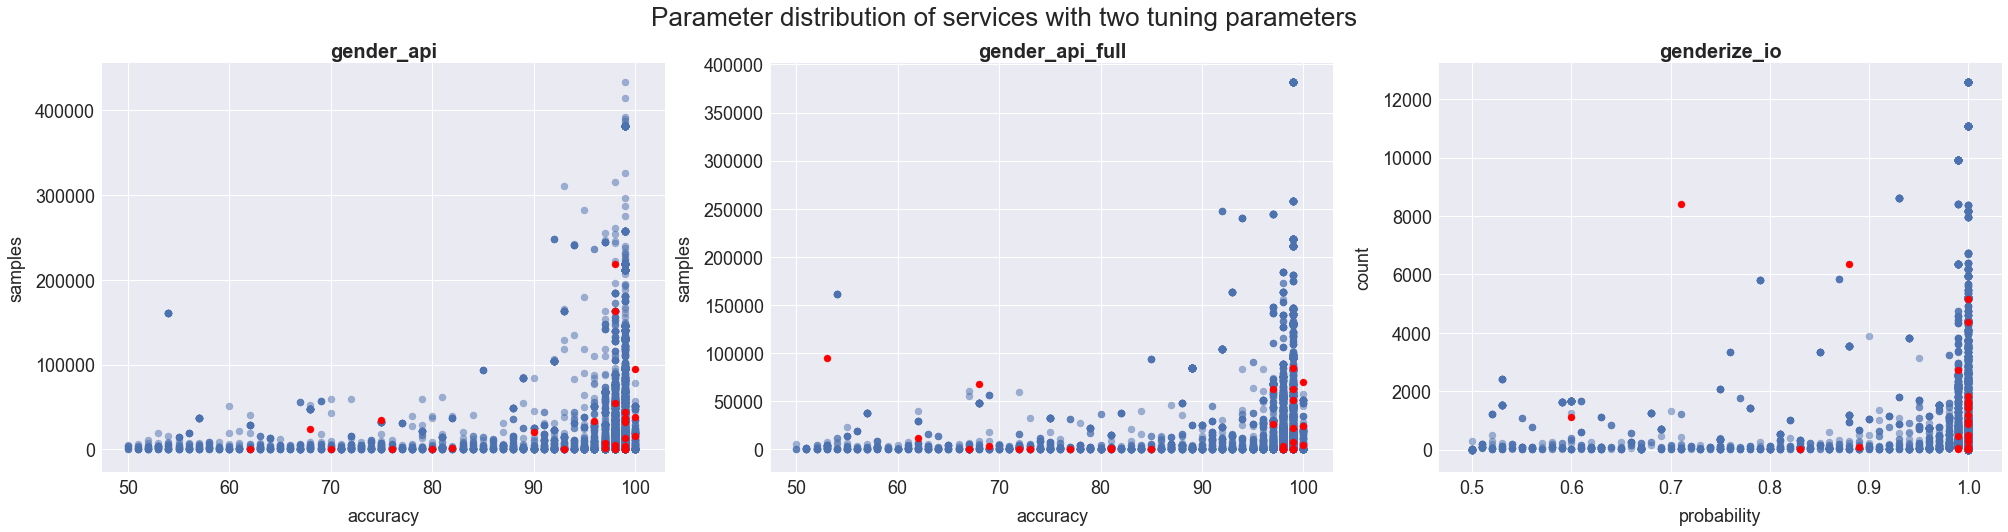

In [14]:
# plot for services with 2 parameters
rows = 1
cols = 3
fs=18
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(28, 7))
cmap = plt.get_cmap('PuRd')


evals = [GenderAPIEvaluator, GenderAPIFullEvaluator, GenderizeIoEvaluator]
for i, e in enumerate(evals):
    evaluator = e('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_tuning_params()
    evaluator._translate_api_response()
    evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

    param_1, param_2 = evaluator.tuning_params[0], evaluator.tuning_params[1]
    evaluator.test_data.plot.scatter(ax=axes[i], x=param_1,  y=param_2, fontsize=fs, alpha=0.5, s=50)
    
    samples = pd.DataFrame.from_dict(grid_30_30[evaluator.gender_evaluator])
    samples = samples[samples.sum(axis=1)!=0] # remove default tuple (0,0)
    samples.head()
    samples.plot.scatter(ax=axes[i], x=param_1, y=param_2, fontsize=fs, c='red', alpha=1, s=50)
    
    axes[i].set_xlabel(param_1.replace("api_", ""), fontsize=fs, labelpad=10)
    axes[i].set_ylabel(param_2.replace("api_", ""), fontsize=fs, labelpad=10)
    axes[i].set_title(evaluator.gender_evaluator,fontweight="bold", size=20)

plt.suptitle('Parameter distribution of services with two tuning parameters', fontsize=fs+8, y=1.05)
fig.tight_layout()

In [15]:
DATA_SOURCES = ['genderize_r_authors', 'genderize_r_titles', 'zbmath', 'wos', 'pubmed']

In [16]:
# print size of the data sets
d = GenderAPIEvaluator('all')
d.load_data(evaluated=True)
for source in DATA_SOURCES:
    print(source, len(d.test_data[d.test_data.origin==source]))

genderize_r_authors 567
genderize_r_titles 470
zbmath 400
wos 3687
pubmed 1952


In [17]:
DATA_SOURCE_TO_GRID_SIZE = {'genderize_r_authors': 20,
                            'genderize_r_titles': 20, 
                            'zbmath': 20, 
                            'wos': 35, 
                            'pubmed': 30
                           }

In [18]:
# Wrapper around some methods to make code for tuning with different error functions shorter
def prepare_for_tuning(e):
    e.load_data(evaluated=True)
    e.preprocess_tuning_params()
    e._translate_api_response()
    e.remove_rows_with_unknown_gender(gender=True, gender_infered=False)
    e.shuffle_data()
    return e

# compute_k_fold_cv_score(self, n_splits, param_range, error_func, random_state=1, constraint_func=None,
#                                 constraint_val=None,
#                                 stratified=True, verbose=False):
def tune(error_func, param_ranges, n_splits=5, random_state=1, data_source='all', 
         constraint_func=None, constraint_val=None, 
         verbose=True):
    service_to_test_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s(data_source)
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)
        
        param_range = param_ranges[evaluator_name]
        mean_test_error = evaluator.compute_k_fold_cv_score(n_splits=n_splits, param_range=param_range, 
                                                            error_func=error_func, random_state=random_state,
                                                            constraint_func=constraint_func, 
                                                            constraint_val=constraint_val, verbose=verbose)
        service_to_test_error[evaluator_name] = mean_test_error
    return service_to_test_error

def tune_repeat(error_func, n_params, n_repeat=10, n_splits=5, data_source='all', 
                constraint_func=None, constraint_val=None, verbose=False):
    """In each of the 'n_repeat' runs, randomly select at most 'n_params' tuning parameters for each evaluator
    and run n_splits-fold CV. The random seed is set per run for bot the tuning params and the CV."""
    service_to_test_error_repeat = []
    for i in range(n_repeat):
        param_ranges = sample_parameters_for_all_services(n_iter=n_params, method='constant', random_state=i)
        # print(param_ranges) # print the params to check that these really differ in each repetition
        service_to_test_error = tune(error_func, param_ranges, n_splits, random_state=i, 
                                     data_source=data_source, constraint_func=constraint_func, 
                                     constraint_val=constraint_val, verbose=verbose)
        service_to_test_error_repeat.append(list(sorted(service_to_test_error.items(), key=lambda t: t[1])))
    return service_to_test_error_repeat

def explore_benchmark(benchmark):
    """Determine services that made it to the first and second place, and create dataframe with their CV errors 
    in each of the repetitions."""
    first_service, second_service = [], []
    for i, item in enumerate(benchmark):
        # print("first place in iteration round ", i, " :", item[0])
        # print("second place in iteration round ", i, " :", item[1])
        first_service.append(item[0][0])
        second_service.append(item[1][0])

    errors_per_service_and_iteration = pd.DataFrame.from_dict([{i[0]:i[1] for i in item} for item in benchmark])
    errors_per_service_and_iteration.index = ['Iteration ' + str(i) for i in errors_per_service_and_iteration.index]
    errors_per_service_and_iteration.loc['average error'] = errors_per_service_and_iteration.mean()

    print("Services at place 1:", Counter(first_service))
    print("Services at place 2:", Counter(second_service))
    display(errors_per_service_and_iteration)
    return errors_per_service_and_iteration

def dump_benchmark_to_file(benchmark_table, file_name):
    writer = pd.ExcelWriter(file_name, engine='xlsxwriter')
    benchmark_table.to_excel(writer, sheet_name='Sheet1')
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']

    worksheet.conditional_format('B12:H12', {'type': '2_color_scale', 'min_color': light_green, 
                                             'max_color': dark_green})
    writer.save()

## Benchmark 2: minimize `error_with_unknown` with the constraint  `error_without_unknown < 0.05`
This benchmark means that the error of classifying women as men or 'unknown' and classifying men as women or 'unknown' is to be minimized, under the constraint that at most 5% of those classified as men or women have been missclassified.

### Benchmark 2 per data source

In [19]:
# 10-fold Cross-Validation per data source and service 
benchmark_2_by_ds = {}

for ds in DATA_SOURCES:
    print("Data source: ", ds)
    n_params = DATA_SOURCE_TO_GRID_SIZE[ds]
    benchmark_2_by_ds[ds] = tune_repeat(error_func=Evaluator.compute_error_with_unknown, 
                                        n_params=n_params, 
                                        n_repeat=1, 
                                        n_splits=10, 
                                        data_source=ds,
                                        constraint_func=Evaluator.compute_error_without_unknown, 
                                        constraint_val=0.05, 
                                        verbose=False)

Data source:  genderize_r_authors
gender_api
gender_api_full
name_api
name_api_full
gender_guesser
genderize_io
namsor
Data source:  genderize_r_titles
gender_api
gender_api_full
name_api
name_api_full
gender_guesser
genderize_io
namsor
Data source:  zbmath
gender_api
gender_api_full
name_api
name_api_full


/opt/projects/meins/ICSU_GenderGap_Project/name_gender_inference/name_gender_inference/evaluator.py:261: RuntimeWarning: invalid value encountered in long_scalars
  conf_matrix.loc['f', 'f_pred'] + conf_matrix.loc['m', 'm_pred'])


No parameter values satisfied given constraint
gender_guesser
genderize_io
namsor
Data source:  wos
gender_api
gender_api_full
name_api
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
name_api_full
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
gender_guesser
No parameter values satisfied given constraint
genderize_io
namsor
Data source:  pubmed
gender_api
gender_api_full
name_api
name_api_full
gender_guesser
genderize_io
namsor


In [20]:
benchmark_2_by_ds

{'genderize_r_authors': [[('gender_api', 0.029044715447154472),
   ('namsor', 0.029102787456445994),
   ('genderize_io', 0.079698025551684079),
   ('gender_guesser', 0.079756097560975597),
   ('name_api_full', 0.10374274099883855),
   ('name_api', 0.20165795586527291),
   ('gender_api_full', 0.2023664343786295)]],
 'genderize_r_titles': [[('gender_api', 0.033913428923835955),
   ('namsor', 0.040163428923835953),
   ('name_api_full', 0.074082639531298164),
   ('gender_guesser', 0.078652096823928458),
   ('genderize_io', 0.082951742213999383),
   ('gender_api_full', 0.13832870798643232),
   ('name_api', 0.26776518655565829)]],
 'pubmed': [[('gender_api', 0.040042324507862444),
   ('genderize_io', 0.069654263195254501),
   ('namsor', 0.06965968868965268),
   ('name_api_full', 0.10296901703605241),
   ('gender_guesser', 0.11540694881498159),
   ('name_api', 0.14403951511904439),
   ('gender_api_full', 0.19970152716364192)]],
 'wos': [[('gender_api', 0.21970275271801989),
   ('namsor', 0.27

In [21]:
# create a DataFrame with services as columns and data sets as rows

def build_benchmark_dataframe(benchmark_as_dict):
    d = {k:sorted(v[0]) for k,v in benchmark_as_dict.items()} # values are a list of list of tuples, and sorted by error 
    df = {}
    for k,v in d.items():
        df[k] = [v[i][1] for i in range(len(v))]
    df_cols = [v[i][0] for i in range(len(v))] # names of columns for the df from the last item only (since all same)
    df = pd.DataFrame.from_dict(df, orient='index')
    df.columns = df_cols
    return df


In [22]:
benchmark_2_by_ds = build_benchmark_dataframe(benchmark_2_by_ds)

In [23]:
benchmark_2_by_ds

,gender_api,gender_api_full,gender_guesser,genderize_io,name_api,name_api_full,namsor
wos,0.219703,0.352822,0.447823,0.330364,0.741221,0.556263,0.275810
genderize_r_authors,0.029045,0.202366,0.079756,0.079698,0.201658,0.103743,0.029103
zbmath,0.008492,0.200215,0.065808,0.065887,0.117670,0.160098,0.042946
genderize_r_titles,0.033913,0.138329,0.078652,0.082952,0.267765,0.074083,0.040163
pubmed,0.040042,0.199702,0.115407,0.069654,0.144040,0.102969,0.069660


### Statistical significance testing

#### Friedman Test

In [24]:
# in order to get also the ranks from the Friedman test, we modify the original scipy implementation
# see https://github.com/scipy/scipy/blob/v1.1.0/scipy/stats/stats.py#L4980-L5094

from scipy.stats import rankdata, tiecorrect, find_repeats, distributions

def f_test(*args):
    
    k = len(args)
    if k < 3:
        raise ValueError('Less than 3 levels.  Friedman test not appropriate.')

    n = len(args[0])
    for i in range(1, k):
        if len(args[i]) != n:
            raise ValueError('Unequal N in friedmanchisquare.  Aborting.')

    # Rank data
    data = np.vstack(args).T
    data = data.astype(float)
    for i in range(len(data)):
        data[i] = rankdata(data[i])

    # Handle ties
    ties = 0
    for i in range(len(data)):
        replist, repnum = find_repeats(array(data[i]))
        for t in repnum:
            ties += t * (t*t - 1)
    c = 1 - ties / float(k*(k*k - 1)*n)

    ssbn = np.sum(data.sum(axis=0)**2)
    chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c

    return data, chisq, distributions.chi2.sf(chisq, k - 1)

In [25]:
# Check the implementation of the scipy method using a random dataframe
df = pd.DataFrame(np.random.randn(6, 4), columns=list('ABCD'))
df = df.apply(lambda x: x**2, axis=1)

df

,A,B,C,D
0,1.570739,0.249894,1.140271,2.075777
1,0.031621,1.777217,3.625420,0.097650
2,0.269142,1.081783,0.203361,0.524147
3,0.376404,1.839436,0.344139,2.692531
4,2.722067,3.307654,0.360817,0.568537
5,0.015084,3.892352,1.129245,3.018369


In [26]:
f_test(*[row for index, row in df.T.iterrows()])

(array([[ 3.,  1.,  2.,  4.],
        [ 1.,  3.,  4.,  2.],
        [ 2.,  4.,  1.,  3.],
        [ 2.,  3.,  1.,  4.],
        [ 3.,  4.,  1.,  2.],
        [ 1.,  4.,  2.,  3.]]), 5.0, 0.17179714429673351)

We see that (a) the method expects the columns of the dataframe as the masurements, and (b) that the rank is performed in an ascending order, which fits with our setting of minimizing errors.

In [27]:
# reduce table by removing the less performing versions of GenderAPI and NameAPI
benchmark_2_by_ds = reduce_table(benchmark_2_by_ds, by_index=False)

In [28]:
benchmark_2_by_ds

,Gender API,NamSor,NameAPI,gender-guesser,genderize.io
genderize_r_authors,0.029045,0.029103,0.103743,0.079756,0.079698
genderize_r_titles,0.033913,0.040163,0.074083,0.078652,0.082952
pubmed,0.040042,0.069660,0.102969,0.115407,0.069654
wos,0.219703,0.275810,0.556263,0.447823,0.330364
zbmath,0.008492,0.042946,0.160098,0.065808,0.065887


In [29]:
f_test(*[row for index, row in benchmark_2_by_ds.T.iterrows()])

(array([[ 1.,  2.,  5.,  4.,  3.],
        [ 1.,  2.,  3.,  4.,  5.],
        [ 1.,  3.,  4.,  5.,  2.],
        [ 1.,  2.,  5.,  4.,  3.],
        [ 1.,  2.,  5.,  3.,  4.]]), 15.519999999999996, 0.0037357596468063337)

We have k = 5 (number of classifiers) and n = 5 (number of datasets).

According to Japkowicz/Shah, Appendix A7, p. 361 (The Friedman Table, lookup for smaller values of n and k), the critical values for the chi-squared distribution of the above k and n are 8.96 for a 0.05 level of significance for a single-tailed test and 11.68 for a 0.01 level of significance. The values for a two-tailed test are 10.24 and 14.4, respectively.

Since 15.52 is larger than all these values, we conclude that there is statistically significant difference among the algorithms on the datasets.


Next we apply post-hoc tests:

In [30]:
# Nemenyi test
from itertools import combinations

def test_nemenyi(ranks_df):
    k,n = ranks_df.shape 
    denom = sqrt((k*(k+1))/(6*n))
    mean_ranks = {col: ranks_df[col].mean() for col in ranks_df.columns}
    pairwise_combs = combinations(ranks_df.columns, 2)
    q_stats = {}
    for pair in pairwise_combs:
        q_stats[pair] = (mean_ranks[pair[0]] - mean_ranks[pair[1]])/denom
    return q_stats

In [31]:
ranks_2 = f_test(*[row for index, row in benchmark_2_by_ds.T.iterrows()])[0]
ranks_2 = pd.DataFrame(ranks_2, columns=benchmark_2_by_ds.columns)

In [32]:
ranks_2

,Gender API,NamSor,NameAPI,gender-guesser,genderize.io
0,1.0,2.0,5.0,4.0,3.0
1,1.0,2.0,3.0,4.0,5.0
2,1.0,3.0,4.0,5.0,2.0
3,1.0,2.0,5.0,4.0,3.0
4,1.0,2.0,5.0,3.0,4.0


In [33]:
test_nemenyi(ranks_2)

{('Gender API', 'NamSor'): -1.2000000000000002,
 ('Gender API', 'NameAPI'): -3.4000000000000004,
 ('Gender API', 'gender-guesser'): -3.0,
 ('Gender API', 'genderize.io'): -2.3999999999999999,
 ('NamSor', 'NameAPI'): -2.2000000000000002,
 ('NamSor', 'gender-guesser'): -1.7999999999999998,
 ('NamSor', 'genderize.io'): -1.1999999999999997,
 ('NameAPI', 'gender-guesser'): 0.40000000000000036,
 ('NameAPI', 'genderize.io'): 1.0000000000000004,
 ('gender-guesser', 'genderize.io'): 0.60000000000000009}

df = (n-1)(k-1) = 16. Values can be looked up from the same table as for the Tukey test (Appendix A8), and then divided by sqrt(2):

* df=16, k=5, alpha=0.05: 4.33
* df=16, k=5, alpha=0.01: 5.49

Divided by sqrt(2), we obtain:

In [34]:
4.33/sqrt(2)

3.0617723625377504

We see that the Nemenyi test is not powerful enough to detect any significant differences between the services' performances, except when comparing Gender API and NameAPI. However, assuming that we are interested in finding the best service, we can in particular compare Gender API with Namsor, since these two obviously perform much better than the other services on each of the data sets. 

Using even the simple (and not very powerful) sign test for two classifiers on multiple domains, we see that Gender API outperforms Namsor with significance level 0.05.

In [35]:
dump_benchmark_to_file(benchmark_table=benchmark_2_by_ds, file_name='Table_test.xlsx')

### Benchmark 2 on the entire data set

We run a 10-fold cross-validation and repeat the procedure with different (but fixed, and hence reproducible) random seeds in order to obtain reliable error estimates. 

In [36]:
benchmark_2_all = tune_repeat(error_func=Evaluator.compute_error_with_unknown, 
                              n_params=40, n_repeat=10, n_splits=10,
                              data_source='all',
                              constraint_func=Evaluator.compute_error_without_unknown, 
                              constraint_val=0.05, 
                              verbose=True)

gender_api
minimal train error: 0.085 corresponding test error: 0.0794473229706
params for lowest train error: {'api_samples': 95042, 'api_accuracy': 56}
minimal train error: 0.0801768890598 corresponding test error: 0.0674740484429
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.0784464526053 corresponding test error: 0.083044982699
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.0965199000192 corresponding test error: 0.122837370242
params for lowest train error: {'api_samples': 38223, 'api_accuracy': 65}
minimal train error: 0.0794078061911 corresponding test error: 0.0743944636678
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.0919054028072 corresponding test error: 0.0934256055363
params for lowest train error: {'api_samples': 154, 'api_accuracy': 80}
minimal train error: 0.0842145741204 corresponding test error: 0.0865051903114
params for lowest tra

minimal train error: 0.146894827918 corresponding test error: 0.148788927336
params for lowest train error: {'api_count': 393.0, 'api_probability': 0.53000000000000003}
minimal train error: 0.142829680892 corresponding test error: 0.142114384749
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.144175317186 corresponding test error: 0.129982668977
params for lowest train error: {'api_count': 0, 'api_probability': 0}
Average test error: 0.144661044336
namsor
minimal train error: 0.13 corresponding test error: 0.112262521589
params for lowest train error: {'api_scale': 0.11}
minimal train error: 0.128052297635 corresponding test error: 0.129757785467
params for lowest train error: {'api_scale': 0.11}
minimal train error: 0.129013651221 corresponding test error: 0.121107266436
params for lowest train error: {'api_scale': 0.11}
minimal train error: 0.142472601423 corresponding test error: 0.186851211073
params for lowest train error: {'api_scale':

minimal train error: 0.224572197654 corresponding test error: 0.202422145329
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.223418573351 corresponding test error: 0.212802768166
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.221688136897 corresponding test error: 0.228373702422
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.22183775471 corresponding test error: 0.227036395147
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.224144559785 corresponding test error: 0.206239168111
params for lowest train error: {'api_confidence': 0.75}
Average test error: 0.222353857489
genderize_io
minimal train error: 0.144038461538 corresponding test error: 0.131260794473
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.144587579312 corresponding test error: 0.126297577855
params for lowest train error: {'api_count': 0, 'api_probability

minimal train error: 0.179388579119 corresponding test error: 0.179930795848
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.181503557008 corresponding test error: 0.160899653979
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.225725821957 corresponding test error: 0.287197231834
params for lowest train error: {'api_confidence': 0.81090200000000001}
minimal train error: 0.18073447414 corresponding test error: 0.167820069204
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.180157661988 corresponding test error: 0.173010380623
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.181695827725 corresponding test error: 0.159169550173
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.180926744857 corresponding test error: 0.166089965398
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.178200692042 corresponding test error: 0.190641247

minimal train error: 0.209727028066 corresponding test error: 0.207972270364
params for lowest train error: {'api_samples': 14121, 'api_accuracy': 60}
minimal train error: 0.207227989235 corresponding test error: 0.190641247834
params for lowest train error: {'api_samples': 8, 'api_accuracy': 87}
Average test error: 0.234629207148
name_api
minimal train error: 0.232115384615 corresponding test error: 0.219343696028
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.231493943472 corresponding test error: 0.22491349481
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.231109402038 corresponding test error: 0.228373702422
params for lowest train error: {'api_confidence': 0}
No parameter values satisfied given constraint
minimal train error: None corresponding test error: 1
params for lowest train error: None
minimal train error: 0.231493943472 corresponding test error: 0.22491349481
params for lowest train error: {'api_confidence': 0}
min

minimal train error: 0.0978657950394 corresponding test error: 0.0899653979239
params for lowest train error: {'api_samples': 50718, 'api_accuracy': 64}
minimal train error: 0.0967121707364 corresponding test error: 0.100346020761
params for lowest train error: {'api_samples': 50718, 'api_accuracy': 64}
minimal train error: 0.0799846183426 corresponding test error: 0.0692041522491
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.0820838139177 corresponding test error: 0.0866551126516
params for lowest train error: {'api_samples': 56, 'api_accuracy': 67}
minimal train error: 0.079969242599 corresponding test error: 0.0693240901213
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
Average test error: 0.0851325552224
gender_api_full
minimal train error: 0.241346153846 corresponding test error: 0.245250431779
params for lowest train error: {'api_samples': 55041, 'api_accuracy': 74}
minimal train error: 0.222457219765 correspondi

minimal train error: 0.129013651221 corresponding test error: 0.121107266436
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.151893866564 corresponding test error: 0.19723183391
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.129398192655 corresponding test error: 0.117647058824
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.129013651221 corresponding test error: 0.121107266436
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.129590463372 corresponding test error: 0.115916955017
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.128821380504 corresponding test error: 0.122837370242
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.155517108804 corresponding test error: 0.164644714038
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.155324875048 corresponding test error: 0.16637781629

minimal train error: 0.144038461538 corresponding test error: 0.131260794473
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.144587579312 corresponding test error: 0.126297577855
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.14266487214 corresponding test error: 0.143598615917
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.146894827918 corresponding test error: 0.179930795848
params for lowest train error: {'api_count': 3702.0, 'api_probability': 0.55000000000000004}
minimal train error: 0.14401076716 corresponding test error: 0.131487889273
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.15016343011 corresponding test error: 0.150519031142
params for lowest train error: {'api_count': 3702.0, 'api_probability': 0.55000000000000004}
minimal train error: 0.144972120746 corresponding test error: 0.15743944636

minimal train error: 0.180926744857 corresponding test error: 0.166089965398
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.178200692042 corresponding test error: 0.190641247834
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.178969627067 corresponding test error: 0.183708838821
params for lowest train error: {'api_confidence': 0}
Average test error: 0.183599497015
gender_guesser
minimal train error: 0.221730769231 corresponding test error: 0.227979274611
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.223034031917 corresponding test error: 0.216262975779
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.22149586618 corresponding test error: 0.230103806228
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.217458181119 corresponding test error: 0.266435986159
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.224187

No parameter values satisfied given constraint
minimal train error: None corresponding test error: 1
params for lowest train error: None
minimal train error: 0.231493943472 corresponding test error: 0.22491349481
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.232070755624 corresponding test error: 0.219723183391
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.230532589887 corresponding test error: 0.233564013841
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.231109402038 corresponding test error: 0.228373702422
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.230103806228 corresponding test error: 0.237435008666
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.232218377547 corresponding test error: 0.218370883882
params for lowest train error: {'api_confidence': 0}
Average test error: 0.303501118027
name_api_full
minimal train error: 0.180576923077

minimal train error: 0.079969242599 corresponding test error: 0.0693240901213
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
Average test error: 0.0889414759838
gender_api_full
minimal train error: 0.243076923077 corresponding test error: 0.246977547496
params for lowest train error: {'api_samples': 8796, 'api_accuracy': 76}
minimal train error: 0.215535473947 corresponding test error: 0.193771626298
params for lowest train error: {'api_samples': 1687, 'api_accuracy': 67}
minimal train error: 0.243414727937 corresponding test error: 0.243944636678
params for lowest train error: {'api_samples': 8796, 'api_accuracy': 76}
minimal train error: 0.264372236108 corresponding test error: 0.266435986159
params for lowest train error: {'api_samples': 12850, 'api_accuracy': 83}
minimal train error: 0.243606998654 corresponding test error: 0.242214532872
params for lowest train error: {'api_samples': 8796, 'api_accuracy': 76}
minimal train error: 0.234954816381 corresponding 

minimal train error: 0.128821380504 corresponding test error: 0.122837370242
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.158785082661 corresponding test error: 0.17157712305
params for lowest train error: {'api_scale': 0.44}
minimal train error: 0.159361783929 corresponding test error: 0.166377816291
params for lowest train error: {'api_scale': 0.44}
Average test error: 0.138274341249
gender_api
minimal train error: 0.0865384615385 corresponding test error: 0.0811744386874
params for lowest train error: {'api_samples': 14894, 'api_accuracy': 57}
minimal train error: 0.0801768890598 corresponding test error: 0.0674740484429
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.0784464526053 corresponding test error: 0.083044982699
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.121130551817 corresponding test error: 0.153979238754
params for lowest train error: {'api_samples':

minimal train error: 0.14401076716 corresponding test error: 0.131487889273
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.17189002115 corresponding test error: 0.176470588235
params for lowest train error: {'api_count': 493.0, 'api_probability': 0.78000000000000003}
minimal train error: 0.147279369352 corresponding test error: 0.159169550173
params for lowest train error: {'api_count': 75.0, 'api_probability': 0.59999999999999998}
minimal train error: 0.148048452221 corresponding test error: 0.152249134948
params for lowest train error: {'api_count': 75.0, 'api_probability': 0.59999999999999998}
minimal train error: 0.142829680892 corresponding test error: 0.142114384749
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.144175317186 corresponding test error: 0.129982668977
params for lowest train error: {'api_count': 0, 'api_probability': 0}
Average test error: 0.147083189664
namsor
minimal train 

In [37]:
errors_per_service_and_iteration_2 = explore_benchmark(benchmark_2_all)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 10})


,gender_api,gender_api_full,gender_guesser,genderize_io,name_api,name_api_full,namsor
Iteration 0,0.083578,0.240863,0.222354,0.144661,0.303501,0.184292,0.133598
Iteration 1,0.090843,0.236011,0.222354,0.145007,0.303501,0.183599,0.136543
Iteration 2,0.084963,0.228232,0.222354,0.146218,0.303501,0.183773,0.133771
Iteration 3,0.086864,0.234629,0.222354,0.144661,0.303501,0.183599,0.133598
Iteration 4,0.085133,0.232209,0.222354,0.146218,0.303501,0.183773,0.136889
Iteration 5,0.091017,0.244835,0.222354,0.144142,0.303501,0.183253,0.140353
Iteration 6,0.086694,0.233936,0.222354,0.146218,0.303501,0.183599,0.134637
Iteration 7,0.082540,0.243104,0.222354,0.145180,0.303501,0.184984,0.136889
Iteration 8,0.088941,0.233419,0.222354,0.144661,0.303501,0.186887,0.138274
Iteration 9,0.086520,0.229616,0.222354,0.147083,0.303501,0.183946,0.134637


The service Gender API comes first in all of the 10 runs, Namsor is second. 

We apply a two-matched-samples t-test to the two best performing services in order to detect whether the performance difference is statistically significant. Since our data set is relatively large, and based on the trust that the gathered data sets were obtained by random sampling, the remaining assumption that needs to be checked is the 'equal variance of the populations' (see also  Japkowicz/Shah, p. 222ff). This can be checked e.g. with Levene's test:

In [38]:
from scipy.stats import levene
levene(errors_per_service_and_iteration_2['gender_api'], errors_per_service_and_iteration_2['namsor'])

LeveneResult(statistic=0.17349926160994672, pvalue=0.6814567109050087)

Since the p-value is large (in particular > 0.05) we can treat the group variances as equal. See also boxplot below:

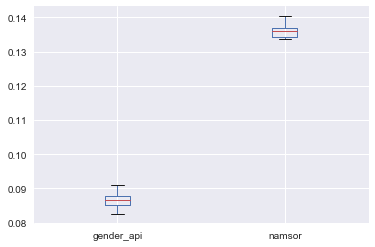

In [39]:
errors_per_service_and_iteration_2[['gender_api','namsor']].boxplot(figsize=(6,4))

In [40]:
from scipy.stats import ttest_rel

In [41]:
ttest_rel(errors_per_service_and_iteration_2['gender_api'], errors_per_service_and_iteration_2['namsor'])

Ttest_relResult(statistic=-69.593499594168776, pvalue=9.1476204569416636e-15)

Since the p-value is very small, we conclude that the performances of the two services differ in a statistically significant manner. We measure the effect size using Cohen's d statistic:

In [42]:
def cohen_d(series_1, series_2):
    return (series_1.mean() - series_2.mean()) / (np.sqrt((series_1.std() ** 2 + series_2.std() ** 2) / 2))

In [43]:
cohen_d(errors_per_service_and_iteration_2['gender_api'], errors_per_service_and_iteration_2['namsor'])

-20.126096842366852

Since the d-statistic is large we conclude that the effect size is large.

## Benchmark 3: minimize `error_without_unknown` with the constraint  `error_unknown < 0.25`
This benchmark can be interpreted as follows: minimize the error of classifying women as men and vice versa, but under the constraint that at most 25% are left as 'unknown'. 

### Benchmark 3 per data source

In [44]:
# 10-fold Cross-Validation per data source and service 
benchmark_3_by_ds = {}

for ds in DATA_SOURCES:
    print("Data source: ", ds)
    n_params = DATA_SOURCE_TO_GRID_SIZE[ds]
    benchmark_3_by_ds[ds] = tune_repeat(error_func=Evaluator.compute_error_without_unknown, 
                                                 n_params=n_params, 
                                                 n_repeat=1, 
                                                 n_splits=10, 
                                                 data_source=ds,
                                                 constraint_func=Evaluator.compute_error_unknown, 
                                                 constraint_val=0.25, verbose=False)

Data source:  genderize_r_authors
gender_api
gender_api_full
name_api
name_api_full
gender_guesser
genderize_io
namsor
Data source:  genderize_r_titles
gender_api
gender_api_full
name_api
No parameter values satisfied given constraint
name_api_full
gender_guesser
genderize_io
namsor
Data source:  zbmath
gender_api
gender_api_full
No parameter values satisfied given constraint
name_api
name_api_full


/opt/projects/meins/ICSU_GenderGap_Project/name_gender_inference/name_gender_inference/evaluator.py:261: RuntimeWarning: invalid value encountered in long_scalars
  conf_matrix.loc['f', 'f_pred'] + conf_matrix.loc['m', 'm_pred'])


gender_guesser
genderize_io
namsor
Data source:  wos
gender_api
gender_api_full
name_api
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
name_api_full
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
gender_guesser
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given constraint
No parameter values satisfied given 

On the data set `wos` with many names of Asian origin, the services `NameAPI` and `gender-guesser`, cannot fullfill the constraint on several of the folds in the cross-validation.

In [45]:
benchmark_3_by_ds

{'genderize_r_authors': [[('gender_api', 0.0025641025641025641),
   ('gender_guesser', 0.0050706033376123234),
   ('namsor', 0.005411255411255411),
   ('name_api_full', 0.0085107835107835102),
   ('genderize_io', 0.014407187936599702),
   ('name_api', 0.016696397857388568),
   ('gender_api_full', 0.021707949308755761)]],
 'genderize_r_titles': [[('gender_api', 0.0022727272727272726),
   ('gender_api_full', 0.0053342816500711234),
   ('gender_guesser', 0.0070478036175710603),
   ('namsor', 0.009832508099517084),
   ('name_api_full', 0.012118471278993117),
   ('genderize_io', 0.017332433648223122),
   ('name_api', 0.119440831232932)]],
 'pubmed': [[('gender_api', 0.0037174738260431217),
   ('genderize_io', 0.0037440820400135863),
   ('namsor', 0.0065043277575841472),
   ('gender_guesser', 0.0067393458220920523),
   ('name_api_full', 0.016378640858009382),
   ('name_api', 0.017254420869517614),
   ('gender_api_full', 0.02474923462248993)]],
 'wos': [[('gender_api', 0.039487013893204075),


In [46]:
benchmark_3_by_ds = build_benchmark_dataframe(benchmark_3_by_ds)

In [47]:
benchmark_3_by_ds

,gender_api,gender_api_full,gender_guesser,genderize_io,name_api,name_api_full,namsor
wos,0.039487,0.088137,1.000000,0.067294,0.904040,0.338985,0.045420
genderize_r_authors,0.002564,0.021708,0.005071,0.014407,0.016696,0.008511,0.005411
zbmath,0.000000,0.110600,0.002857,0.006083,0.003846,0.013739,0.000000
genderize_r_titles,0.002273,0.005334,0.007048,0.017332,0.119441,0.012118,0.009833
pubmed,0.003717,0.024749,0.006739,0.003744,0.017254,0.016379,0.006504


In [48]:
benchmark_3_by_ds = reduce_table(benchmark_3_by_ds, by_index=False)

In [49]:
benchmark_3_by_ds

,Gender API,NamSor,NameAPI,gender-guesser,genderize.io
genderize_r_authors,0.002564,0.005411,0.008511,0.005071,0.014407
genderize_r_titles,0.002273,0.009833,0.012118,0.007048,0.017332
pubmed,0.003717,0.006504,0.016379,0.006739,0.003744
wos,0.039487,0.045420,0.338985,1.000000,0.067294
zbmath,0.000000,0.000000,0.013739,0.002857,0.006083


In [92]:
f_test(*[row for index, row in benchmark_3_by_ds.T.iterrows()])

(array([[ 1. ,  3. ,  4. ,  2. ,  5. ],
        [ 1. ,  3. ,  4. ,  2. ,  5. ],
        [ 1. ,  3. ,  4. ,  2. ,  5. ],
        [ 1. ,  3. ,  4. ,  2. ,  5. ],
        [ 1.5,  3. ,  4. ,  1.5,  5. ]]),
 19.838383838383841,
 0.00053745261946131146)

As in benchmark 1, the Friedman test shows statistical significance. However, again the Nemanyi test is not powerful to detect differences in performance. Also, the sign test will not detect statistical significance between Gender API and Namsor which are the best performing services in this benchmark, since for the data set `zbmath`, both show perfect performance.

(We do not apply any further tests here for the best two algorithms, like the Wilcoxon's Signed-Rank Test, since they are not well suited for 5 data sets.)

### Benchmark 3 on the entire data set

In [71]:
benchmark_3_all = tune_repeat(error_func=Evaluator.compute_error_without_unknown, 
                              n_params=40, 
                              n_repeat=10, 
                               n_splits=10, 
                              constraint_func=Evaluator.compute_error_unknown, 
                              constraint_val=0.25, 
                              verbose=True)

gender_api
minimal train error: 0.00764865531705 corresponding test error: 0.0132450331126
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00787789266371 corresponding test error: 0.0112612612613
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00841792522902 corresponding test error: 0.00642398286938
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.0210616806361 corresponding test error: 0.0239520958084
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.00816225575068 corresponding test error: 0.00863930885529
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.0086291913215 corresponding test error: 0.00444444444444
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00838471023428 corresponding test error:

minimal train error: 0.0148315736551 corresponding test error: 0.00881057268722
params for lowest train error: {'api_count': 3561.0, 'api_probability': 0.95999999999999996}
minimal train error: 0.0142749812171 corresponding test error: 0.0136674259681
params for lowest train error: {'api_count': 3561.0, 'api_probability': 0.95999999999999996}
minimal train error: 0.0150338261087 corresponding test error: 0.00680272108844
params for lowest train error: {'api_count': 3561.0, 'api_probability': 0.95999999999999996}
minimal train error: 0.0130653266332 corresponding test error: 0.0243362831858
params for lowest train error: {'api_count': 3561.0, 'api_probability': 0.95999999999999996}
minimal train error: 0.0137913741224 corresponding test error: 0.018018018018
params for lowest train error: {'api_count': 3561.0, 'api_probability': 0.95999999999999996}
minimal train error: 0.0137844611529 corresponding test error: 0.0180995475113
params for lowest train error: {'api_count': 3561.0, 'api_pr

minimal train error: 0.0281945162959 corresponding test error: 0.0274599542334
params for lowest train error: {'api_confidence': 0.86804899999999996}
minimal train error: 0.0304347826087 corresponding test error: 0.0306345733042
params for lowest train error: {'api_confidence': 0.80918400000000001}
minimal train error: 0.027446918695 corresponding test error: 0.0340136054422
params for lowest train error: {'api_confidence': 0.86804899999999996}
Average test error: 0.0304623045292
gender_guesser
minimal train error: 0.025758305248 corresponding test error: 0.0324675324675
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0264996386413 corresponding test error: 0.0258064516129
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0271504084575 corresponding test error: 0.0198237885463
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0256164711515 corresponding test error: 0.0341685649203
params for lowest

minimal train error: 0.0375901132853 corresponding test error: 0.0387243735763
params for lowest train error: {'api_confidence': 0.82566600000000001}
minimal train error: 0.0390268626457 corresponding test error: 0.0405405405405
params for lowest train error: {'api_confidence': 0.80730500000000005}
minimal train error: 0.0385901723694 corresponding test error: 0.0298165137615
params for lowest train error: {'api_confidence': 0.82566600000000001}
minimal train error: 0.036480157752 corresponding test error: 0.0654627539503
params for lowest train error: {'api_confidence': 0.77317999999999998}
minimal train error: 0.0402327935223 corresponding test error: 0.0296803652968
params for lowest train error: {'api_confidence': 0.80730500000000005}
minimal train error: 0.0397267206478 corresponding test error: 0.0342465753425
params for lowest train error: {'api_confidence': 0.80730500000000005}
minimal train error: 0.0397138628515 corresponding test error: 0.0358744394619
params for lowest trai

minimal train error: 0.00842302292934 corresponding test error: 0.0132450331126
params for lowest train error: {'api_samples': 130215, 'api_accuracy': 91}
minimal train error: 0.0073417721519 corresponding test error: 0.00890868596882
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.00782828282828 corresponding test error: 0.00455580865604
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.00758150113723 corresponding test error: 0.00678733031674
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.00758341759353 corresponding test error: 0.00677200902935
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.00782630648826 corresponding test error: 0.00456621004566
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.00756429652042 corresponding test error: 0.00692

minimal train error: 0.0149925037481 corresponding test error: 0.00678733031674
params for lowest train error: {'api_count': 2548.0, 'api_probability': 0.95999999999999996}
minimal train error: 0.0130325814536 corresponding test error: 0.0242290748899
params for lowest train error: {'api_count': 2548.0, 'api_probability': 0.95999999999999996}
minimal train error: 0.0137534383596 corresponding test error: 0.0179775280899
params for lowest train error: {'api_count': 2548.0, 'api_probability': 0.95999999999999996}
minimal train error: 0.01375 corresponding test error: 0.018018018018
params for lowest train error: {'api_count': 2548.0, 'api_probability': 0.95999999999999996}
Average test error: 0.0149226244665
namsor
minimal train error: 0.0141497926323 corresponding test error: 0.011013215859
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0138821237214 corresponding test error: 0.0134228187919
params for lowest train error: {'api_scale': 0.7099999

minimal train error: 0.025758305248 corresponding test error: 0.0324675324675
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0264996386413 corresponding test error: 0.0258064516129
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0271504084575 corresponding test error: 0.0198237885463
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0256164711515 corresponding test error: 0.0341685649203
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0124159337817 corresponding test error: 0.0268456375839
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.0147172734314 corresponding test error: 0.00681818181818
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.0139390810532 corresponding test error: 0.0136674259681
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.0255175734232 corresponding test er

minimal train error: 0.0374819798174 corresponding test error: 0.0669642857143
params for lowest train error: {'api_confidence': 0.727854}
minimal train error: 0.0386881885729 corresponding test error: 0.0299539170507
params for lowest train error: {'api_confidence': 0.82223299999999999}
minimal train error: 0.0410330678252 corresponding test error: 0.03426124197
params for lowest train error: {'api_confidence': 0.727854}
minimal train error: 0.0409342643872 corresponding test error: 0.035010940919
params for lowest train error: {'api_confidence': 0.727854}
minimal train error: 0.0409441233141 corresponding test error: 0.0349344978166
params for lowest train error: {'api_confidence': 0.727854}
minimal train error: 0.0366262574155 corresponding test error: 0.048275862069
params for lowest train error: {'api_confidence': 0.82841200000000004}
minimal train error: 0.0376414846012 corresponding test error: 0.0366132723112
params for lowest train error: {'api_confidence': 0.84492199999999995

minimal train error: 0.00957720158841 corresponding test error: 0.012474012474
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.0100303242361 corresponding test error: 0.00842105263158
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.0102444703143 corresponding test error: 0.00642398286938
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
Average test error: 0.00988777398609
gender_api_full
minimal train error: 0.0383480825959 corresponding test error: 0.0396475770925
params for lowest train error: {'api_samples': 28436, 'api_accuracy': 77}
minimal train error: 0.0280710790626 corresponding test error: 0.0229357798165
params for lowest train error: {'api_samples': 97659, 'api_accuracy': 83}
minimal train error: 0.0278350515464 corresponding test error: 0.0250569476082
params for lowest train error: {'api_samples': 97659, 'api_accuracy': 83}
minimal train error: 0.0

minimal train error: 0.0141497926323 corresponding test error: 0.011013215859
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0138821237214 corresponding test error: 0.0134228187919
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0119727891156 corresponding test error: 0.00689655172414
params for lowest train error: {'api_scale': 0.87}
minimal train error: 0.0131259115216 corresponding test error: 0.0205011389522
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.012987012987 corresponding test error: 0.021186440678
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0139330237106 corresponding test error: 0.012987012987
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0141878669276 corresponding test error: 0.010752688172
params for lowest train error: {'api_scale': 0.70999999999999996}
mini

minimal train error: 0.0124159337817 corresponding test error: 0.0268456375839
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.0147172734314 corresponding test error: 0.00681818181818
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.0139390810532 corresponding test error: 0.0136674259681
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.0255175734232 corresponding test error: 0.034632034632
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.026455026455 corresponding test error: 0.0262008733624
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0144777662875 corresponding test error: 0.00898876404494
params for lowest train error: {'api_confidence': 1.0}
Average test error: 0.0229419254957
genderize_io
minimal train error: 0.0134428678118 corresponding test error: 0.0110619469027
params for lowest train error: {'api_count': 12593.0, 'api_probabi

minimal train error: 0.0402284579091 corresponding test error: 0.031746031746
params for lowest train error: {'api_confidence': 0.78023100000000001}
minimal train error: 0.0385284613473 corresponding test error: 0.047191011236
params for lowest train error: {'api_confidence': 0.78023100000000001}
minimal train error: 0.0395916334661 corresponding test error: 0.037610619469
params for lowest train error: {'api_confidence': 0.78023100000000001}
Average test error: 0.0395656534054
name_api_full
minimal train error: 0.0331291127751 corresponding test error: 0.0437375745527
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0341706268387 corresponding test error: 0.0346232179226
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0271983100079 corresponding test error: 0.0229357798165
params for lowest train error: {'api_confidence': 0.87301600000000001}
minimal train error: 0.0319316393074 corresponding test error: 0.0561555075594
params for

minimal train error: 0.0365071534287 corresponding test error: 0.0377777777778
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 76}
minimal train error: 0.024523871641 corresponding test error: 0.0207373271889
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 85}
minimal train error: 0.0242693110647 corresponding test error: 0.0229885057471
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 85}
minimal train error: 0.0281690140845 corresponding test error: 0.0391705069124
params for lowest train error: {'api_samples': 39712, 'api_accuracy': 83}
minimal train error: 0.0237535891412 corresponding test error: 0.0275229357798
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 85}
minimal train error: 0.0367175948743 corresponding test error: 0.0358744394619
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 76}
minimal train error: 0.036049382716 corresponding test error: 0.0418502202643
pa

minimal train error: 0.012987012987 corresponding test error: 0.021186440678
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0139330237106 corresponding test error: 0.012987012987
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0141878669276 corresponding test error: 0.010752688172
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0136518771331 corresponding test error: 0.0155210643016
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0138753651412 corresponding test error: 0.0134831460674
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0138922739459 corresponding test error: 0.0133333333333
params for lowest train error: {'api_scale': 0.70999999999999996}
Average test error: 0.0139113301539


In [72]:
errors_per_service_and_iteration_3 = explore_benchmark(benchmark_3_all)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 9, 'genderize_io': 1})


,gender_api,gender_api_full,gender_guesser,genderize_io,name_api,name_api_full,namsor
Iteration 0,0.009468,0.030999,0.022942,0.015496,0.038839,0.030181,0.013861
Iteration 1,0.008727,0.033634,0.022942,0.013972,0.039434,0.030462,0.013861
Iteration 2,0.006149,0.031949,0.022942,0.014808,0.039058,0.029947,0.013861
Iteration 3,0.007896,0.031463,0.022942,0.014923,0.039454,0.030152,0.013908
Iteration 4,0.011243,0.033616,0.022942,0.023172,0.040663,0.030151,0.013861
Iteration 5,0.008195,0.035415,0.022942,0.015357,0.039368,0.028804,0.013861
Iteration 6,0.009888,0.035104,0.022942,0.027625,0.039378,0.029419,0.013910
Iteration 7,0.010195,0.039983,0.022942,0.013893,0.038844,0.030412,0.013861
Iteration 8,0.009225,0.035398,0.022942,0.013843,0.039566,0.032202,0.013861
Iteration 9,0.007475,0.031950,0.022942,0.020564,0.039296,0.030441,0.013911


In [73]:
errors_per_service_and_iteration_3 = reduce_table(errors_per_service_and_iteration_3, by_index=False)

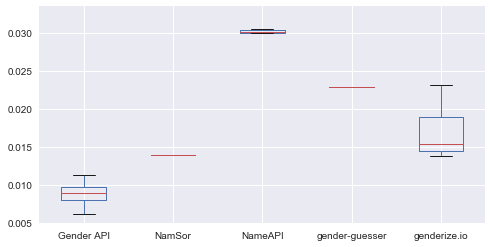

In [74]:
errors_per_service_and_iteration_3.boxplot(figsize=(8,4))

We see that the variances of Gender API and Namsor are not equal, hence a t test cannot be applied. However, it can be applied to the comparison of Gender API with genderize.io and of NamSor and gender-guesser, for instance (see also below that in these cases, the p-value of Levene's test is large enough).

In [75]:
levene(errors_per_service_and_iteration_3['Gender API'], errors_per_service_and_iteration_3['NamSor'])

LeveneResult(statistic=15.807409013423118, pvalue=0.00074438348169854676)

In [76]:
levene(errors_per_service_and_iteration_3['Gender API'], errors_per_service_and_iteration_3['genderize.io'])

LeveneResult(statistic=2.5652905682587801, pvalue=0.12490986038553979)

In [77]:
ttest_rel(errors_per_service_and_iteration_3['Gender API'], errors_per_service_and_iteration_3['genderize.io'])

Ttest_relResult(statistic=-6.7163863036156526, pvalue=5.2565278896188942e-05)

In [78]:
cohen_d(errors_per_service_and_iteration_3['Gender API'], errors_per_service_and_iteration_3['genderize.io'])

-2.5403980070308108

The p-value of the t test is very small, and Cohen's d statistic ls large, hence the performances of Gender API and genderize.io differ significantly and the effect size is large.

In [80]:
# dump_benchmark_to_file(benchmark_table=df, file_name= DIR_PATH + '/paper/submission/Table4.xlsx')

## Benchmark 4: minimize `weighted_error` with weight w=0.2
The 'weighted error' with weight w=0.2 puts 5 times more weight on classifying women as men and vice versa than classifying both of them as 'unknown'

### Benchmark 4 per data source

In [81]:
# 10-fold Cross-Validation per data source and service 
benchmark_4_by_ds = {}

for ds in DATA_SOURCES:
    print("Data source: ", ds)
    n_params = DATA_SOURCE_TO_GRID_SIZE[ds]
    benchmark_4_by_ds[ds] = tune_repeat(error_func=Evaluator.compute_weighted_error, 
                                        n_params=n_params, 
                                        n_repeat=1, 
                                        n_splits=10, 
                                        data_source=ds,
                                        verbose=False)

Data source:  genderize_r_authors
gender_api
gender_api_full
name_api
name_api_full
gender_guesser
genderize_io
namsor
Data source:  genderize_r_titles
gender_api
gender_api_full
name_api
name_api_full
gender_guesser
genderize_io
namsor
Data source:  zbmath
gender_api
gender_api_full
name_api
name_api_full
gender_guesser
genderize_io
namsor
Data source:  wos
gender_api
gender_api_full
name_api
name_api_full
gender_guesser
genderize_io
namsor
Data source:  pubmed
gender_api
gender_api_full
name_api
name_api_full
gender_guesser
genderize_io
namsor


In [82]:
benchmark_4_by_ds

{'genderize_r_authors': [[('gender_api', 0.013019653630882578),
   ('namsor', 0.013037886542217159),
   ('gender_guesser', 0.021056704866699083),
   ('genderize_io', 0.026908560005567912),
   ('name_api_full', 0.033695349418249747),
   ('name_api', 0.046193309128817792),
   ('gender_api_full', 0.079345853986608025)]],
 'genderize_r_titles': [[('gender_api', 0.017646702141717558),
   ('namsor', 0.021957185197444603),
   ('name_api_full', 0.025085828788360808),
   ('gender_guesser', 0.032142608649087558),
   ('genderize_io', 0.036293453534398959),
   ('gender_api_full', 0.040142842062073317),
   ('name_api', 0.05239443744660751)]],
 'pubmed': [[('gender_api', 0.024322208903324413),
   ('genderize_io', 0.027291515429844881),
   ('namsor', 0.031454228924468752),
   ('gender_guesser', 0.033504846038303851),
   ('name_api_full', 0.038576204654964384),
   ('name_api', 0.047365863988186034),
   ('gender_api_full', 0.072565879826931828)]],
 'wos': [[('gender_api', 0.079123360676263271),
   ('na

In [83]:
benchmark_4_by_ds = build_benchmark_dataframe(benchmark_4_by_ds)

In [89]:
benchmark_4_by_ds = reduce_table(benchmark_4_by_ds, by_index=False)

In [90]:
f_test(*[row for index, row in benchmark_4_by_ds.T.iterrows()])

(array([[ 1.,  2.,  5.,  3.,  4.],
        [ 1.,  2.,  3.,  4.,  5.],
        [ 1.,  3.,  5.,  4.,  2.],
        [ 1.,  2.,  4.,  5.,  3.],
        [ 1.,  2.,  5.,  3.,  4.]]), 15.200000000000003, 0.0043038823275892467)

Again, since the F statistic 15.2 is larger than all relevant values for the F test, we conclude that there is statistically significant difference among the algorithms on the datasets.


In [91]:
ranks_4 = f_test(*[row for index, row in benchmark_4_by_ds.T.iterrows()])[0]
ranks_4 = pd.DataFrame(ranks_4, columns=benchmark_4_by_ds.columns)
test_nemenyi(ranks_4)

{('Gender API', 'NamSor'): -1.2000000000000002,
 ('Gender API', 'NameAPI'): -3.4000000000000004,
 ('Gender API', 'gender-guesser'): -2.7999999999999998,
 ('Gender API', 'genderize.io'): -2.6000000000000001,
 ('NamSor', 'NameAPI'): -2.2000000000000002,
 ('NamSor', 'gender-guesser'): -1.5999999999999996,
 ('NamSor', 'genderize.io'): -1.3999999999999999,
 ('NameAPI', 'gender-guesser'): 0.60000000000000053,
 ('NameAPI', 'genderize.io'): 0.80000000000000027,
 ('gender-guesser', 'genderize.io'): 0.19999999999999973}

### Benchmark 4 on all data

In [25]:
benchmark_4_all = tune_repeat(error_func=Evaluator.compute_weighted_error, 
                              n_params=40, 
                              n_repeat=10, 
                              n_splits=10,
                              verbose=True)

gender_api
minimal train error: 0.0447655139744 corresponding test error: 0.0435193945128
params for lowest train error: {'api_accuracy': 76, 'api_samples': 139211}
minimal train error: 0.0435583691595 corresponding test error: 0.0483932670237
params for lowest train error: {'api_accuracy': 76, 'api_samples': 139211}
minimal train error: 0.0445603223513 corresponding test error: 0.0443396226415
params for lowest train error: {'api_accuracy': 76, 'api_samples': 139211}
minimal train error: 0.044885177453 corresponding test error: 0.0430532054898
params for lowest train error: {'api_accuracy': 76, 'api_samples': 139211}
minimal train error: 0.0448135529055 corresponding test error: 0.043321299639
params for lowest train error: {'api_accuracy': 76, 'api_samples': 139211}
Average test error: 0.0445253578613
gender_api_full
minimal train error: 0.0892498148344 corresponding test error: 0.0845813119595
params for lowest train error: {'api_accuracy': 78, 'api_samples': 68146}
minimal train er

minimal train error: 0.066794267766 corresponding test error: 0.069006543724
params for lowest train error: {'api_confidence': 0}
Average test error: 0.0672876376538
namsor
minimal train error: 0.0563352635195 corresponding test error: 0.0540273105086
params for lowest train error: {'api_scale': 0.5}
minimal train error: 0.0534671620904 corresponding test error: 0.0612764291308
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0558982079549 corresponding test error: 0.0515267175573
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0559694272446 corresponding test error: 0.0511727078891
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0533159319412 corresponding test error: 0.0618316157885
params for lowest train error: {'api_scale': 0.40999999999999998}
Average test error: 0.0559669561748
gender_guesser
minimal train error: 0.0726597172051 corresponding test error: 0.07

minimal train error: 0.0449973783307 corresponding test error: 0.0439497716895
params for lowest train error: {'api_accuracy': 78, 'api_samples': 78387}
minimal train error: 0.0450858778626 corresponding test error: 0.0436018957346
params for lowest train error: {'api_accuracy': 78, 'api_samples': 78387}
minimal train error: 0.0447057703295 corresponding test error: 0.0467522513892
params for lowest train error: {'api_accuracy': 79, 'api_samples': 46085}
Average test error: 0.0452649774882
gender_api_full
minimal train error: 0.0895177746751 corresponding test error: 0.0854572713643
params for lowest train error: {'api_accuracy': 81, 'api_samples': 101742}
minimal train error: 0.0881736607383 corresponding test error: 0.090811965812
params for lowest train error: {'api_accuracy': 81, 'api_samples': 101742}
minimal train error: 0.0889568905352 corresponding test error: 0.0876929674099
params for lowest train error: {'api_accuracy': 81, 'api_samples': 101742}
minimal train error: 0.08688

minimal train error: 0.0534531922092 corresponding test error: 0.0615203761755
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.0558879322924 corresponding test error: 0.0517570664629
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.0559643687064 corresponding test error: 0.05137186223
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.0533017041053 corresponding test error: 0.0620743335279
params for lowest train error: {'api_scale': 0.42999999999999999}
Average test error: 0.056150189781
gender_guesser
minimal train error: 0.0726597172051 corresponding test error: 0.0750256937307
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0712272610812 corresponding test error: 0.0810067681895
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0753867646298 corresponding test error: 0.0642799023596
params for lowest train

minimal train error: 0.0896518060527 corresponding test error: 0.087069525666
params for lowest train error: {'api_accuracy': 83, 'api_samples': 97659}
minimal train error: 0.0871870243032 corresponding test error: 0.0967607973422
params for lowest train error: {'api_accuracy': 77, 'api_samples': 28436}
minimal train error: 0.0892679608602 corresponding test error: 0.088519764508
params for lowest train error: {'api_accuracy': 77, 'api_samples': 28436}
minimal train error: 0.0876110028157 corresponding test error: 0.0952692391541
params for lowest train error: {'api_accuracy': 83, 'api_samples': 97659}
minimal train error: 0.0898742411101 corresponding test error: 0.0861732146733
params for lowest train error: {'api_accuracy': 83, 'api_samples': 97659}
Average test error: 0.0907585082687
name_api
minimal train error: 0.0860575435702 corresponding test error: 0.0855517171307
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0828250730357 corresponding test erro

minimal train error: 0.0533017041053 corresponding test error: 0.0620743335279
params for lowest train error: {'api_scale': 0.42999999999999999}
Average test error: 0.056150189781
gender_guesser
minimal train error: 0.0726597172051 corresponding test error: 0.0750256937307
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0712272610812 corresponding test error: 0.0810067681895
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0753867646298 corresponding test error: 0.0642799023596
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0723724963865 corresponding test error: 0.0761650585095
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0740454076367 corresponding test error: 0.0695044211392
params for lowest train error: {'api_confidence': 0.75}
Average test error: 0.0731963687857
genderize_io
minimal train error: 0.06575235872 corresponding test error: 0.0612401612594
para

minimal train error: 0.088056837629 corresponding test error: 0.0914735099338
params for lowest train error: {'api_accuracy': 73, 'api_samples': 72376}
minimal train error: 0.0866680489322 corresponding test error: 0.0970350404313
params for lowest train error: {'api_accuracy': 73, 'api_samples': 72376}
minimal train error: 0.0890710382514 corresponding test error: 0.0873103144931
params for lowest train error: {'api_accuracy': 85, 'api_samples': 219085}
Average test error: 0.0912470063995
name_api
minimal train error: 0.0860575435702 corresponding test error: 0.0855517171307
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0828250730357 corresponding test error: 0.0986677768526
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0881036877025 corresponding test error: 0.077380952381
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0870123203285 corresponding test error: 0.081695966908
params for lowest train

In [26]:
errors_per_service_and_iteration_3 = explore_benchmark(benchmark_3)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 10})


,gender_api,gender_api_full,gender_guesser,genderize_io,name_api,name_api_full,namsor
Iteration 0,0.044525,0.089017,0.073196,0.063204,0.085985,0.067288,0.056704
Iteration 1,0.044815,0.088707,0.073196,0.064662,0.085985,0.067288,0.055967
Iteration 2,0.044914,0.090620,0.073196,0.061195,0.085985,0.067288,0.057229
Iteration 3,0.045265,0.088707,0.073196,0.062675,0.085985,0.067288,0.057326
Iteration 4,0.046126,0.088270,0.073196,0.064157,0.085985,0.067288,0.056150
Iteration 5,0.045043,0.088382,0.073196,0.061743,0.086094,0.067288,0.055907
Iteration 6,0.045567,0.090759,0.073196,0.062774,0.085985,0.067288,0.056132
Iteration 7,0.045166,0.093437,0.073196,0.066102,0.085985,0.067288,0.056150
Iteration 8,0.049177,0.089108,0.073196,0.061697,0.085985,0.067288,0.057052
Iteration 9,0.047413,0.091247,0.073196,0.062140,0.085985,0.067288,0.056132


In [27]:
df = errors_per_service_and_iteration_3
df = reduce_table(df, by_index=False)
df = df.round(3)
df

,Gender API,NamSor,NameAPI,gender-guesser,genderize.io
Iteration 0,0.045,0.057,0.067,0.073,0.063
Iteration 1,0.045,0.056,0.067,0.073,0.065
Iteration 2,0.045,0.057,0.067,0.073,0.061
Iteration 3,0.045,0.057,0.067,0.073,0.063
Iteration 4,0.046,0.056,0.067,0.073,0.064
Iteration 5,0.045,0.056,0.067,0.073,0.062
Iteration 6,0.046,0.056,0.067,0.073,0.063
Iteration 7,0.045,0.056,0.067,0.073,0.066
Iteration 8,0.049,0.057,0.067,0.073,0.062
Iteration 9,0.047,0.056,0.067,0.073,0.062


In [28]:
dump_benchmark_to_file(benchmark_table=df, file_name=DIR_PATH + '/paper/submission/Table5.xlsx')

## Compute models for each benchmark

In [29]:
def compute_final_models(error_func, constraint_func, constraint_val, n_params=40):
    service_to_best_param = {}
    param_ranges = sample_parameters_for_all_services(n_iter=n_params, method='constant', random_state=1)
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        
        evaluator = prepare_for_tuning(evaluator)
        param_range = param_ranges[evaluator_name]
        train_index = evaluator.test_data.index
        test_index = evaluator.test_data.index # train and test index the same since we are only looking for best model
        test_error, train_error, best_param = evaluator.tune_params(param_range, error_func, train_index, test_index, 
                                                                constraint_func, constraint_val)
        print("Evaluator name: ", evaluator_name)
        print("Error: ", train_error)
        service_to_best_param[evaluator_name] = best_param
        
    return service_to_best_param

def explore_models(service, params):
    e = service('all')
    e.load_data(evaluated=True)
    e.preprocess_tuning_params()
    e._translate_api_response(**params)
    return e

In [30]:
print("Benchmark 1:")
# Optimal model parameters for Benchmark 1
service_to_best_param_1 = compute_final_models(error_func=Evaluator.compute_error_with_unknown,
                                               constraint_func=Evaluator.compute_error_without_unknown, 
                                               constraint_val=0.05)
print("Benchmark 2:")
# Optimal model parameters for Benchmark 2
service_to_best_param_2 = compute_final_models(error_func=Evaluator.compute_error_without_unknown, 
                                               constraint_func=Evaluator.compute_error_unknown, 
                                               constraint_val=0.25)
print("Benchmark 3:")
# Optimal model parameters for Benchmark 3
service_to_best_param_3 = compute_final_models(error_func=Evaluator.compute_weighted_error,
                                               constraint_func=None, 
                                               constraint_val=None)

Benchmark 1:
Evaluator name:  gender_api
Error:  0.0799446270981
Evaluator name:  gender_api_full
Error:  0.254715348676
Evaluator name:  name_api
Error:  0.230835784738
Evaluator name:  name_api_full
Error:  0.179442810175
Evaluator name:  namsor
Error:  0.12822287593
Evaluator name:  gender_guesser
Error:  0.222356809137
Evaluator name:  genderize_io
Error:  0.146392109361
Benchmark 2:
Evaluator name:  gender_api
Error:  0.0100650031453
Evaluator name:  gender_api_full
Error:  0.0303791685701
Evaluator name:  name_api
Error:  0.0390376758965
Evaluator name:  name_api_full
Error:  0.0304546443333
Evaluator name:  namsor
Error:  0.0138370305293
Evaluator name:  gender_guesser
Error:  0.0264298093588
Evaluator name:  genderize_io
Error:  0.0127272727273
Benchmark 3:
Evaluator name:  gender_api
Error:  0.0448126529844
Evaluator name:  gender_api_full
Error:  0.088703791164
Evaluator name:  name_api
Error:  0.0859551717047
Evaluator name:  name_api_full
Error:  0.0672331720367
Evaluator n

### Optimal values of the tuning parameter per service and benchmark metric

In [31]:
service_to_best_param_1

{'gender_api': {'api_accuracy': 57, 'api_samples': 62},
 'gender_api_full': {'api_accuracy': 89, 'api_samples': 1458},
 'gender_guesser': {'api_confidence': 0.75},
 'genderize_io': {'api_count': 4373.0, 'api_probability': 0.52000000000000002},
 'name_api': {'api_confidence': 0},
 'name_api_full': {'api_confidence': 0},
 'namsor': {'api_scale': 0.13}}

In [32]:
service_to_best_param_2

{'gender_api': {'api_accuracy': 90, 'api_samples': 137366},
 'gender_api_full': {'api_accuracy': 81, 'api_samples': 104026},
 'gender_guesser': {'api_confidence': 0.75},
 'genderize_io': {'api_count': 8180.0, 'api_probability': 0.95999999999999996},
 'name_api': {'api_confidence': 0.80226399999999998},
 'name_api_full': {'api_confidence': 0.80918400000000001},
 'namsor': {'api_scale': 0.70999999999999996}}

In [33]:
service_to_best_param_3

{'gender_api': {'api_accuracy': 75, 'api_samples': 72003},
 'gender_api_full': {'api_accuracy': 81, 'api_samples': 104026},
 'gender_guesser': {'api_confidence': 0.75},
 'genderize_io': {'api_count': 445.0, 'api_probability': 0.75},
 'name_api': {'api_confidence': 0},
 'name_api_full': {'api_confidence': 0},
 'namsor': {'api_scale': 0.40999999999999998}}

### Benchmark 1

In [34]:
# Gender API
gender_api = explore_models(GenderAPIEvaluator, service_to_best_param_1['gender_api'])
gender_api_errors_m_f = gender_api.compare_ground_truth_with_inference(gender='m', 
                                                                       gender_infered='f').sort_values('api_accuracy',
                                                                                                       ascending=False)
gender_api_errors_f_m = gender_api.compare_ground_truth_with_inference(gender='f', 
                                                                       gender_infered='m').sort_values('api_accuracy',
                                                                                                       ascending=False)
# NamSor
namsor = explore_models(NamSorEvaluator, service_to_best_param_1['namsor'])
namsor_errors_m_f = namsor.compare_ground_truth_with_inference(gender='m',
                                                               gender_infered='f').sort_values('api_scale',
                                                                                               ascending=False)
namsor_errors_f_m = namsor.compare_ground_truth_with_inference(gender='f',
                                                               gender_infered='m').sort_values('api_scale',
                                                                                               ascending=False)

# NameAPI
name_api = explore_models(NameAPIFullEvaluator, service_to_best_param_1['name_api_full'])
name_api_errors_m_f = name_api.compare_ground_truth_with_inference(gender='m',
                                                                   gender_infered='f').sort_values('api_confidence',
                                                                                                   ascending=False)
name_api_errors_f_m = name_api.compare_ground_truth_with_inference(gender='f',
                                                                   gender_infered='m').sort_values('api_confidence',
                                                                                                   ascending=False)

# genderize.io
genderize_io = explore_models(GenderizeIoEvaluator, service_to_best_param_1['genderize_io'])
genderize_io_errors_m_f = genderize_io.compare_ground_truth_with_inference(gender='m',
                                                                           gender_infered='f').sort_values('api_probability',
                                                                                                           ascending=False)
genderize_io_errors_f_m = genderize_io.compare_ground_truth_with_inference(gender='f',
                                                                           gender_infered='m').sort_values('api_probability',
                                                                                                           ascending=False)

# gender-guesser
gender_guesser = explore_models(GenderGuesserEvaluator, service_to_best_param_1['gender_guesser'])
gender_guesser_errors_m_f = gender_guesser.compare_ground_truth_with_inference(gender='m',
                                                                               gender_infered='f').sort_values('api_confidence',
                                                                                                               ascending=False)
gender_guesser_errors_f_m = gender_guesser.compare_ground_truth_with_inference(gender='f',
                                                                               gender_infered='m').sort_values('api_confidence',
                                                                                                               ascending=False)

In [35]:
print("Number of m-f errors by Gender API:", len(gender_api_errors_m_f))
print("Number of m-f errors by NamSor:", len(namsor_errors_m_f))
print("Number of m-f errors by NameAPI:", len(name_api_errors_m_f))
print("Number of m-f errors by genderize_io:", len(genderize_io_errors_m_f))
print("Number of m-f errors by gender-guesser:", len(gender_guesser_errors_m_f))

Number of m-f errors by Gender API: 104
Number of m-f errors by NamSor: 131
Number of m-f errors by NameAPI: 93
Number of m-f errors by genderize_io: 175
Number of m-f errors by gender-guesser: 66


In [36]:
print("Number of f-m errors by Gender API:", len(gender_api_errors_f_m))
print("Number of f-m errors by NamSor:", len(namsor_errors_f_m))
print("Number of f-m errors by NameAPI:", len(name_api_errors_f_m))
print("Number of f-m errors by genderize_io:", len(genderize_io_errors_f_m))
print("Number of f-m errors by gender-guesser:", len(gender_guesser_errors_f_m))

Number of f-m errors by Gender API: 170
Number of f-m errors by NamSor: 93
Number of f-m errors by NameAPI: 75
Number of f-m errors by genderize_io: 68
Number of f-m errors by gender-guesser: 56


In [37]:
print("Gender Bias for Gender API:", gender_api.compute_all_errors()[2])
print("Gender Bias for NamSor:", namsor.compute_all_errors()[2])
print("Gender Bias for genderize_io:", genderize_io.compute_all_errors()[2])
print("Gender Bias for NameAPI:", name_api.compute_all_errors()[2])
print("Gender Bias for gender_guesser:", gender_guesser.compute_all_errors()[2])

Gender Bias for Gender API: -0.0118046861027
Gender Bias for NamSor: 0.00722158874952
Gender Bias for genderize_io: 0.0206723338485
Gender Bias for NameAPI: 0.00366598778004
Gender Bias for gender_guesser: 0.00216637781629


Genderize_io introduces the highest Gender Bias. It makes false classifications more frequently for men than fr women. Gender API introduces the second highest Gender Bias and misclassifies more freuqently women as men than the other way around.

In [38]:
namsor_errors_m_f

,first_name,middle_name,last_name,full_name,gender,origin,api_firstName,api_gender,api_lastName,api_scale,gender_infered
5108,aza,,mohammed,aza mohammed,m,nature,aza,female,mohammed,1.00,f
3808,natsuki,,matsumoto,natsuki matsumoto,m,nature,natsuki,female,matsumoto,1.00,f
5094,jani,,sainio,jani sainio,m,nature,jani,female,sainio,1.00,f
5067,tomomi,,matsui,tomomi matsui,m,nature,tomomi,female,matsui,1.00,f
5060,lakshmi,,narasimhan,lakshmi narasimhan,m,nature,lakshmi,female,narasimhan,1.00,f
5039,hiromi,,yamashita,hiromi yamashita,m,nature,hiromi,female,yamashita,1.00,f
2664,devi,,nampiaparampil,devi nampiaparampil,m,filardo,devi,female,nampiaparampil,1.00,f
3005,arathi,,setty,arathi setty,m,filardo,arathi,female,setty,1.00,f
1142,ashley,,morris,ashley morris,m,genderizeR_titles,ashley,female,morris,1.00,f
3651,didarul,,chowdhury,didarul chowdhury,m,nature,didarul,female,chowdhury,1.00,f


In [39]:
namsor_errors_f_m

,first_name,middle_name,last_name,full_name,gender,origin,api_firstName,api_gender,api_lastName,api_scale,gender_infered
3595,puay,hoon,tan,puay hoon tan,f,nature,puay hoon,male,tan,1.00,m
724,comrade,,parvati,comrade parvati,f,genderizeR,comrade,male,parvati,1.00,m
3624,saim,,norashikin,saim norashikin,f,nature,saim,male,norashikin,1.00,m
3474,subramaniam,,mythily,subramaniam mythily,f,nature,subramaniam,male,mythily,1.00,m
2124,rory,,collins,rory collins,f,filardo,rory,male,collins,1.00,m
6153,minh,,huynh,minh huynh,f,nature,minh,male,huynh,1.00,m
3548,keo,,tabane,keo tabane,f,nature,keo,male,tabane,1.00,m
2317,mishal,sameer,khan,mishal sameer khan,f,filardo,mishal sameer,male,khan,1.00,m
4601,fernanda,rodrigues,fernandes,fernanda rodrigues fernandes,f,nature,fernanda-rodrigues,male,fernandes,1.00,m
1813,terry,,davis,terry davis,f,filardo,terry,male,davis,0.99,m


### Benchmark 2

As seen above, the services `Gender API`, `genderize.io` and `NamSor` have very similar error values.

In [40]:
# Gender API
gender_api = explore_models(GenderAPIEvaluator, service_to_best_param_2['gender_api'])
gender_api_errors_m_f = gender_api.compare_ground_truth_with_inference(gender='m', 
                                                                       gender_infered='f').sort_values('api_accuracy',
                                                                                                       ascending=False)
gender_api_errors_f_m = gender_api.compare_ground_truth_with_inference(gender='f', 
                                                                       gender_infered='m').sort_values('api_accuracy',
                                                                                                       ascending=False)
# NamSor
namsor = explore_models(NamSorEvaluator, service_to_best_param_2['namsor'])
namsor_errors_m_f = namsor.compare_ground_truth_with_inference(gender='m',
                                                               gender_infered='f').sort_values('api_scale',
                                                                                               ascending=False)
namsor_errors_f_m = namsor.compare_ground_truth_with_inference(gender='f',
                                                               gender_infered='m').sort_values('api_scale',
                                                                                               ascending=False)

# NameAPI
name_api = explore_models(NameAPIFullEvaluator, service_to_best_param_2['name_api_full'])
name_api_errors_m_f = name_api.compare_ground_truth_with_inference(gender='m',
                                                                   gender_infered='f').sort_values('api_confidence',
                                                                                                   ascending=False)
name_api_errors_f_m = name_api.compare_ground_truth_with_inference(gender='f',
                                                                   gender_infered='m').sort_values('api_confidence',
                                                                                                   ascending=False)

# genderize.io
genderize_io = explore_models(GenderizeIoEvaluator, service_to_best_param_2['genderize_io'])
genderize_io_errors_m_f = genderize_io.compare_ground_truth_with_inference(gender='m',
                                                                           gender_infered='f').sort_values('api_probability',
                                                                                                           ascending=False)
genderize_io_errors_f_m = genderize_io.compare_ground_truth_with_inference(gender='f',
                                                                           gender_infered='m').sort_values('api_probability',
                                                                                                           ascending=False)

# gender-guesser
gender_guesser = explore_models(GenderGuesserEvaluator, service_to_best_param_2['gender_guesser'])
gender_guesser_errors_m_f = gender_guesser.compare_ground_truth_with_inference(gender='m',
                                                                               gender_infered='f').sort_values('api_confidence',
                                                                                                               ascending=False)
gender_guesser_errors_f_m = gender_guesser.compare_ground_truth_with_inference(gender='f',
                                                                               gender_infered='m').sort_values('api_confidence',
                                                                                                               ascending=False)

In [41]:
print("Number of m-f errors by Gender API:", len(gender_api_errors_m_f))
print("Number of m-f errors by NamSor:", len(namsor_errors_m_f))
print("Number of m-f errors by NameAPI:", len(name_api_errors_m_f))
print("Number of m-f errors by genderize_io:", len(genderize_io_errors_m_f))
print("Number of m-f errors by gender-guesser:", len(gender_guesser_errors_m_f))

Number of m-f errors by Gender API: 15
Number of m-f errors by NamSor: 40
Number of m-f errors by NameAPI: 77
Number of m-f errors by genderize_io: 40
Number of m-f errors by gender-guesser: 66


In [42]:
print("Number of f-m errors by Gender API:", len(gender_api_errors_f_m))
print("Number of f-m errors by NamSor:", len(namsor_errors_f_m))
print("Number of f-m errors by NameAPI:", len(name_api_errors_f_m))
print("Number of f-m errors by genderize_io:", len(genderize_io_errors_f_m))
print("Number of f-m errors by gender-guesser:", len(gender_guesser_errors_f_m))

Number of f-m errors by Gender API: 33
Number of f-m errors by NamSor: 23
Number of f-m errors by NameAPI: 63
Number of f-m errors by genderize_io: 16
Number of f-m errors by gender-guesser: 56


In [43]:
print("Gender Bias for Gender API:", gender_api.compute_all_errors()[2])
print("Gender Bias for NamSor:", namsor.compute_all_errors()[2])
print("Gender Bias for genderize_io:", genderize_io.compute_all_errors()[2])
print("Gender Bias for NameAPI:", name_api.compute_all_errors()[2])
print("Gender Bias for gender_guesser:", gender_guesser.compute_all_errors()[2])

Gender Bias for Gender API: -0.00377437617949
Gender Bias for NamSor: 0.00373380188886
Gender Bias for genderize_io: 0.00545454545455
Gender Bias for NameAPI: 0.00304546443333
Gender Bias for gender_guesser: 0.00216637781629


All services have relatively low gender bias. Again, Gender API favors men over women, and genderize.io introduces the highest bias.

In [44]:
gender_api_errors_f_m

,first_name,middle_name,last_name,full_name,gender,origin,api_accuracy,api_duration,gender_infered,api_name,api_samples,api_gender
6204,chang,hyun,kim,chang hyun kim,f,nature,100,32ms,m,chang hyun,39,male
5210,yongfu,,he,yongfu he,f,nature,100,23ms,m,yongfu,12,male
3391,yongsoon,,park,yongsoon park,f,nature,100,43ms,m,yongsoon,6,male
3474,subramaniam,,mythily,subramaniam mythily,f,nature,100,17ms,m,subramaniam,205,male
3476,soshan,,cheong,soshan cheong,f,nature,100,18ms,m,soshan,5,male
5204,zhongqiang,,yang,zhongqiang yang,f,nature,100,82ms,m,zhongqiang,4,male
3495,suryun,,ham,suryun ham,f,nature,100,29ms,m,suryun,3,male
3563,titipun,,thongtem,titipun thongtem,f,nature,100,18ms,m,titipun,3,male
3589,sangwoon,,yoon,sangwoon yoon,f,nature,100,28ms,m,sangwoon,11,male
6220,taciana,marco,ferraz caneppele,taciana marco ferraz caneppele,f,nature,99,96ms,m,taciana-marco,132431,male


In [45]:
namsor_errors_f_m

,first_name,middle_name,last_name,full_name,gender,origin,api_firstName,api_gender,api_lastName,api_scale,gender_infered
724,comrade,,parvati,comrade parvati,f,genderizeR,comrade,male,parvati,1.00,m
3474,subramaniam,,mythily,subramaniam mythily,f,nature,subramaniam,male,mythily,1.00,m
6153,minh,,huynh,minh huynh,f,nature,minh,male,huynh,1.00,m
4601,fernanda,rodrigues,fernandes,fernanda rodrigues fernandes,f,nature,fernanda-rodrigues,male,fernandes,1.00,m
3595,puay,hoon,tan,puay hoon tan,f,nature,puay hoon,male,tan,1.00,m
3548,keo,,tabane,keo tabane,f,nature,keo,male,tabane,1.00,m
3624,saim,,norashikin,saim norashikin,f,nature,saim,male,norashikin,1.00,m
2317,mishal,sameer,khan,mishal sameer khan,f,filardo,mishal sameer,male,khan,1.00,m
2124,rory,,collins,rory collins,f,filardo,rory,male,collins,1.00,m
1813,terry,,davis,terry davis,f,filardo,terry,male,davis,0.99,m


### Benchmark 3:

In [46]:
# Gender API
gender_api = explore_models(GenderAPIEvaluator, service_to_best_param_3['gender_api'])
gender_api_errors_m_f = gender_api.compare_ground_truth_with_inference(gender='m', 
                                                                       gender_infered='f').sort_values('api_accuracy',
                                                                                                       ascending=False)
gender_api_errors_f_m = gender_api.compare_ground_truth_with_inference(gender='f', 
                                                                       gender_infered='m').sort_values('api_accuracy',
                                                                                                       ascending=False)
# NamSor
namsor = explore_models(NamSorEvaluator, service_to_best_param_3['namsor'])
namsor_errors_m_f = namsor.compare_ground_truth_with_inference(gender='m',
                                                               gender_infered='f').sort_values('api_scale',
                                                                                               ascending=False)
namsor_errors_f_m = namsor.compare_ground_truth_with_inference(gender='f',
                                                               gender_infered='m').sort_values('api_scale',
                                                                                               ascending=False)

# NameAPI
name_api = explore_models(NameAPIFullEvaluator, service_to_best_param_3['name_api_full'])
name_api_errors_m_f = name_api.compare_ground_truth_with_inference(gender='m',
                                                                   gender_infered='f').sort_values('api_confidence',
                                                                                                   ascending=False)
name_api_errors_f_m = name_api.compare_ground_truth_with_inference(gender='f',
                                                                   gender_infered='m').sort_values('api_confidence',
                                                                                                   ascending=False)

# genderize.io
genderize_io = explore_models(GenderizeIoEvaluator, service_to_best_param_3['genderize_io'])
genderize_io_errors_m_f = genderize_io.compare_ground_truth_with_inference(gender='m',
                                                                           gender_infered='f').sort_values('api_probability',
                                                                                                           ascending=False)
genderize_io_errors_f_m = genderize_io.compare_ground_truth_with_inference(gender='f',
                                                                           gender_infered='m').sort_values('api_probability',
                                                                                                           ascending=False)

# gender-guesser
gender_guesser = explore_models(GenderGuesserEvaluator, service_to_best_param_3['gender_guesser'])
gender_guesser_errors_m_f = gender_guesser.compare_ground_truth_with_inference(gender='m',
                                                                               gender_infered='f').sort_values('api_confidence',
                                                                                                               ascending=False)
gender_guesser_errors_f_m = gender_guesser.compare_ground_truth_with_inference(gender='f',
                                                                               gender_infered='m').sort_values('api_confidence',
                                                                                                               ascending=False)

In [47]:
print("Number of m-f errors by Gender API:", len(gender_api_errors_m_f))
print("Number of m-f errors by NamSor:", len(namsor_errors_m_f))
print("Number of m-f errors by NameAPI:", len(name_api_errors_m_f))
print("Number of m-f errors by genderize_io:", len(genderize_io_errors_m_f))
print("Number of m-f errors by gender-guesser:", len(gender_guesser_errors_m_f))

Number of m-f errors by Gender API: 45
Number of m-f errors by NamSor: 69
Number of m-f errors by NameAPI: 93
Number of m-f errors by genderize_io: 121
Number of m-f errors by gender-guesser: 66


In [48]:
print("Number of f-m errors by Gender API:", len(gender_api_errors_f_m))
print("Number of f-m errors by NamSor:", len(namsor_errors_f_m))
print("Number of f-m errors by NameAPI:", len(name_api_errors_f_m))
print("Number of f-m errors by genderize_io:", len(genderize_io_errors_f_m))
print("Number of f-m errors by gender-guesser:", len(gender_guesser_errors_f_m))

Number of f-m errors by Gender API: 76
Number of f-m errors by NamSor: 62
Number of f-m errors by NameAPI: 75
Number of f-m errors by genderize_io: 45
Number of f-m errors by gender-guesser: 56


In [49]:
print("Gender Bias for Gender API:", gender_api.compute_all_errors()[2])
print("Gender Bias for NamSor:", namsor.compute_all_errors()[2])
print("Gender Bias for genderize_io:", genderize_io.compute_all_errors()[2])
print("Gender Bias for NameAPI:", name_api.compute_all_errors()[2])
print("Gender Bias for gender_guesser:", gender_guesser.compute_all_errors()[2])

Gender Bias for Gender API: -0.00596842510589
Gender Bias for NamSor: 0.00139636943946
Gender Bias for genderize_io: 0.0152702431183
Gender Bias for NameAPI: 0.00366598778004
Gender Bias for gender_guesser: 0.00216637781629


Again, genderize_io introduces the highest bias, and Gender API is the only service favoring men over women.

## Exploration of the parameter space for the benchmark winner  `genderAPI`

In [50]:
gender_api = GenderAPIEvaluator('all')
gender_api.load_data(evaluated=True)
gender_api.preprocess_tuning_params()
gender_api._translate_api_response()
gender_api.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

gender_api_range = gender_api.sample_parameters(n_iter=40, method='square', random_state=0)

In [51]:
len(gender_api_range)

1393

In [52]:
error_with_unknown = gender_api.compute_error_for_param_range(param_range=gender_api_range, 
                                                              error_func=Evaluator.compute_error_with_unknown, 
                                                              index=evaluator.test_data.index)

error_without_unknown = gender_api.compute_error_for_param_range(param_range=gender_api_range, 
                                                                 error_func=Evaluator.compute_error_without_unknown, 
                                                                 index=evaluator.test_data.index)

In [53]:
df_error_with_unknown = pd.Series(error_with_unknown).reset_index()
df_error_without_unknown = pd.Series(error_without_unknown).reset_index()

df_error_with_unknown.columns=['samples', 'accuracy', 'error_with_unknown']
df_error_without_unknown.columns=['samples', 'accuracy', 'error_without_unknown']

In [54]:
df_error_with_unknown.head()

,samples,accuracy,error_with_unknown
0,0,0,0.050412
1,50,22561,0.050412
2,50,34211,0.050412
3,51,1741,0.050779
4,51,3076,0.050779


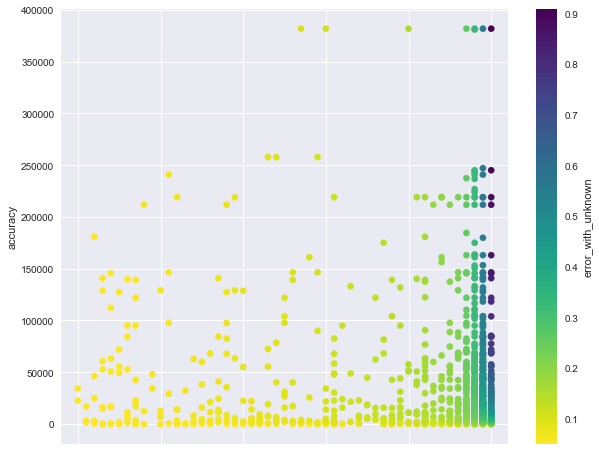

In [55]:
df_error_with_unknown.plot.scatter(x='samples', y='accuracy', c='error_with_unknown', xlim=(48,102), 
                                   cmap=plt.cm.get_cmap('viridis_r'), s=40, figsize=(10,8))

Here, we see the expected trend: the higher either of the parameter values, the higher the `error_with_unknown`.

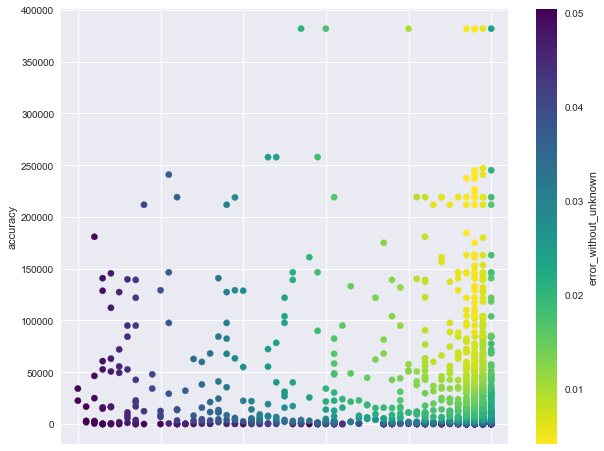

In [56]:
df_error_without_unknown.plot.scatter(x='samples', y='accuracy', c='error_without_unknown', xlim=(48,102), 
                                      cmap=plt.cm.get_cmap('viridis_r'), s=40, figsize=(10,8))

The tendency with the `error_without_unknown` is that the higher both parameter values the lower the error. 
However, the far right column is not intuitive and further exploration might be interesting.